# AutoTrader Challenge

## Setup

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow # For accessing parquet files
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import PredictionErrorDisplay, mean_absolute_error, mean_squared_error

In [2]:
data_path= f"rate_of_sale_may_2023.snappy.parquet" 

data_dict_path = f"rate_of_sale_data_dict.csv" 

df = pd.read_parquet(data_path) 

category_descriptions = pd.read_csv(data_dict_path) 

In [3]:
df.head(10)



,stock_item_id,last_date_seen,first_date_seen,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,can_home_deliver,reviews_per_100_advertised_stock_last_12_months,segment,seats,...,odometer_reading_miles,first_registration_date,attention_grabber,manufacturer_approved,price_indicator_rating,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality,postcode_area
0,52ae009b671ab58b3d4ff109a9fbdcf8d847de0fa190e1...,2023-05-05,2021-03-25,771,6995,6495.0,False,3.9,Independent,5.0,...,65000,2004-05-07,*IMMACULATE**FULL HISTORY*,False,NOANALYSIS,NaN,NaN,50,NaN,AL
1,32b1bac6934b1f64ff43cffa9df5aa296ead8143c36f9f...,2023-05-09,2021-05-25,714,13725,14995.0,False,NaN,Franchise,5.0,...,16018,2019-11-30,Sports Styling | Great Economy,True,GOOD,14848.0,26078.0,15,57.0,HP
2,21703d22d87eaa95c4dc81a60ba2c8cbe3b90ab659292c...,2023-05-12,2021-11-26,532,15499,13999.0,False,0.2,Independent,5.0,...,31093,2018-03-08,"Sat Nav,Leather,Auto,Euro 6",False,GREAT,14571.0,34732.0,22,61.0,SR
3,661acafc271373946cea7d30ac7f34257404ab89a1ad33...,2023-05-16,2022-02-17,453,10995,9995.0,False,7.9,Franchise,5.0,...,79000,2015-07-02,Viewing by APPOINTMENT ONLY,False,FAIR,9349.0,65684.0,30,61.0,FY
4,638216dc92410d965b416fea5b3cec9ca903368795fdde...,2023-05-04,2022-03-21,409,46000,37500.0,False,6.8,Franchise,5.0,...,10214,2022-03-03,Reserve Online,True,GOOD,37055.0,11765.0,22,48.0,LE
5,e3c8b08856a8736bb48c38f083d42f43f3e3e8e3466610...,2023-05-21,2022-04-27,389,1395,1295.0,False,2.6,Independent,5.0,...,91000,2009-03-25,8 MONTHS MOT,False,NOANALYSIS,2285.0,61512.0,15,NaN,RG
6,82369d8013f2ab13f8f49fb780797298a8dd19974d3b60...,2023-05-14,2022-06-06,342,8257,7457.0,False,NaN,Independent,5.0,...,58849,2015-03-18,"£0 ROAD TAX, 1/2 LEATHER SEATS",False,LOW,8145.0,52450.0,24,54.0,PE
7,1fd13f137d7ed19e993b07dd1708992582537e56efb863...,2023-05-03,2022-06-16,321,23500,19500.0,False,1.2,Independent,5.0,...,40000,2017-11-30,LOW MILEAGE AUTOMATIC,False,NOANALYSIS,24662.0,52255.0,23,44.0,N
8,c34a29671d55abf60ea1ab1c23ad21a0a7437c8ffea756...,2023-05-16,2022-06-23,327,96950,84950.0,False,NaN,Independent,4.0,...,5000,2018-03-29,Mulliner Driving Specification,False,NOANALYSIS,96290.0,23167.0,9,NaN,HP
9,db6f342f73f5c7819fef4254e6886387eac15e026878ab...,2023-05-22,2022-06-24,332,15995,15695.0,False,NaN,Independent,5.0,...,34000,2018-11-07,DEPOSIT TAKEN ON THIS CAR,False,GOOD,15973.0,37233.0,30,65.0,CO


In [4]:
df.isna().sum()

# drop na and work out feature importance first

stock_item_id                                           0
last_date_seen                                          0
first_date_seen                                         0
days_to_sell                                            0
first_retailer_asking_price                             0
last_retailer_asking_price                            929
can_home_deliver                                        0
reviews_per_100_advertised_stock_last_12_months     33266
segment                                                32
seats                                                 129
doors                                                   4
co2_emission_gpkm                                     117
top_speed_mph                                         653
zero_to_sixty_mph_seconds                          143152
engine_power_bhp                                        2
fuel_economy_wltp_combined_mpg                       6868
battery_range_miles                                213494
battery_usable

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224555 entries, 0 to 224554
Data columns (total 42 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   stock_item_id                                    224555 non-null  object 
 1   last_date_seen                                   224555 non-null  object 
 2   first_date_seen                                  224555 non-null  object 
 3   days_to_sell                                     224555 non-null  int32  
 4   first_retailer_asking_price                      224555 non-null  int64  
 5   last_retailer_asking_price                       223626 non-null  float64
 6   can_home_deliver                                 224555 non-null  bool   
 7   reviews_per_100_advertised_stock_last_12_months  191289 non-null  float64
 8   segment                                          224523 non-null  object 
 9   seats          

In [6]:
category_descriptions.head(10)

,Field,Description
0,stock_item_id,Unique ID of the advert e.g. 8a42801e86dad35a0...
1,last_date_seen,The date the vehicle was last seen advertised ...
2,first_date_seen,The first date the vehicle was listed on Auto ...
3,days_to_sell,The difference in days between first_date_seen...
4,first_retailer_asking_price,The price the advert had when first created. T...
5,last_retailer_asking_price,The last seen price
6,can_home_deliver,This advert is able to be delivered to the buy...
7,reviews_per_100_advertised_stock_last_12_months,How many reviews the seller has recieved in th...
8,segment,Whether the seller is a Franchise or Independe...
9,seats,Number of seats in the vehicle


## Data Sanitisation

### Drop Irrelevant Columns

In [7]:
df = df[df['stock_item_id'] != '6e0bc864bc4906de2ee2f20287772e9f3fa6fd788b7f7e9e29304c7c8c40dcfd']

In [8]:
df = df.drop(columns=['stock_item_id', 'derivative', 'derivative_id', 'generation', 'colour', 'boot_space_seats_up_litres', 'first_registration_date'])

In [9]:
df['zero_to_sixty_mph_seconds'] = df['zero_to_sixty_mph_seconds'].astype(float)
df['engine_power_bhp'] = df['engine_power_bhp'].astype(float)
df['fuel_economy_wltp_combined_mpg'] = df['fuel_economy_wltp_combined_mpg'].astype(float)
df['battery_usable_capacity_kwh'] = df['battery_usable_capacity_kwh'].astype(float)
df['length_mm'] = df['length_mm'].astype(float)
df['insurance_group'] = df['insurance_group'].astype(float)

In [10]:
df = df.dropna(subset=['plate'])
contains_letter = df['plate'].str.contains('[a-zA-Z]', regex=True)
df.loc[contains_letter, 'plate'] = 1

In [11]:
df['plate'] = df['plate'].astype(float)

In [12]:
non_elec = df['fuel_type'].isin(['Petrol', 'Diesel', 'Bi_fuel'])
df.loc[non_elec, 'battery_usable_capacity_kwh'] = 0
df.loc[non_elec, 'battery_range_miles'] = 0

In [13]:
df['battery_usable_capacity_kwh'].isnull().sum()

12944

In [14]:
filtered_df = df[(~df['fuel_type'].isin(['Petrol', 'Diesel', 'Bi_fuel'])) & (df['battery_usable_capacity_kwh'] == 0)]

# Step 2: Compute the mean 'battery_usable_capacity_kwh' for each 'make'
mean_capacity_by_make = df.groupby('make')['battery_usable_capacity_kwh'].mean()

# Step 3: Replace 0 values in 'battery_usable_capacity_kwh' with the mean value per make
for make, mean_capacity in mean_capacity_by_make.items():
    df.loc[(df['make'] == make) & (df['battery_usable_capacity_kwh'] == 0), 'battery_usable_capacity_kwh'] = mean_capacity

In [15]:
df['battery_usable_capacity_kwh'].isnull().sum()

12944

In [16]:
df['price_indicator_rating'].unique()

array(['NOANALYSIS', 'GOOD', 'GREAT', 'FAIR', 'LOW', 'HIGH'], dtype=object)

In [17]:
df['price_indicator_rating'] = df['price_indicator_rating'].replace({'NOANALYSIS': 0, 'GOOD': 1, 'GREAT': 2, 'FAIR': 3, 'LOW': 4, 'HIGH': 5})
df['price_indicator_rating'] = df['price_indicator_rating'].astype(int)
df = df[df['last_retailer_asking_price'] != 1]
df['last_retailer_asking_price'] = df['last_retailer_asking_price'].fillna(df['first_retailer_asking_price'])

In [18]:
df['reviews_per_100_advertised_stock_last_12_months'] = df['reviews_per_100_advertised_stock_last_12_months'].clip(upper=100)

mean_reviews = df['reviews_per_100_advertised_stock_last_12_months'].mean()
df['reviews_per_100_advertised_stock_last_12_months'] = df['reviews_per_100_advertised_stock_last_12_months'].fillna(mean_reviews)



In [19]:
df = df.dropna(subset=['segment'])
df = df.dropna(subset=['doors'])
for sts in df['doors'].unique():
    if df[(df['doors'] == sts) & (df['seats'].isnull())].empty:
        continue
    mseats = df[df['doors'] == sts]['seats'].mode()
    if not mseats.empty:
        df.loc[(df['doors'] == sts) & (df['seats'].isnull()), 'seats'] = mseats.iloc[0]

In [20]:
df.loc[df['fuel_type'] == 'Electric', 'co2_emission_gpkm'] = 0
for emissions in df['fuel_type'].unique():
    if df[(df['fuel_type'] == emissions) & (df['co2_emission_gpkm'].isnull())].empty:
        continue
    emiss = df[df['fuel_type'] == emissions]['co2_emission_gpkm'].mode()
    if not emiss.empty:
        df.loc[(df['fuel_type'] == emissions) & (df['co2_emission_gpkm'].isnull()), 'co2_emission_gpkm'] = emiss.iloc[0]


In [21]:
for mk in df['make'].unique():
    if df[(df['make'] == mk) & (df['model'].isnull())].empty:
        continue
    mdl = df[df['make'] == mk]['model'].mode()
    if not mdl.empty:
        df.loc[(df['make'] == mk) & (df['model'].isnull()), 'model'] = mdl.iloc[0]

In [22]:
for mod in df['model'].unique():
    if df[(df['model'] == mod) & (df['top_speed_mph'].isnull())].empty:
        continue
    tspeed = df[df['model'] == mod]['top_speed_mph'].mode()
    if not tspeed.empty:
        df.loc[(df['model'] == mod) & (df['top_speed_mph'].isnull()), 'top_speed_mph'] = tspeed.iloc[0]

In [23]:
df = df.dropna(subset=['top_speed_mph'])

In [24]:
for tsm in df['model'].unique():
    if df[(df['model'] == tsm) & (df['zero_to_sixty_mph_seconds'].isnull())].empty:
        continue
    zts = df[df['model'] == tsm]['zero_to_sixty_mph_seconds'].mode()
    if not zts.empty:
        df.loc[(df['model'] == tsm) & (df['zero_to_sixty_mph_seconds'].isnull()), 'zero_to_sixty_mph_seconds'] = zts.iloc[0]

In [25]:
for tsm in df['make'].unique():
    if df[(df['make'] == tsm) & (df['zero_to_sixty_mph_seconds'].isnull())].empty:
        continue
    zts = df[df['make'] == tsm]['zero_to_sixty_mph_seconds'].mode()
    if not zts.empty:
        df.loc[(df['make'] == tsm) & (df['zero_to_sixty_mph_seconds'].isnull()), 'zero_to_sixty_mph_seconds'] = zts.iloc[0]

In [26]:
df = df.dropna(subset=['zero_to_sixty_mph_seconds'])
df = df.dropna(subset=['engine_power_bhp'])

In [27]:
for fmpg in df['model'].unique():
    if df[(df['model'] == fmpg) & (df['fuel_economy_wltp_combined_mpg'].isnull())].empty:
        continue
    mwltp = df[df['model'] == fmpg]['fuel_economy_wltp_combined_mpg'].mode()
    if not mwltp.empty:
        df.loc[(df['model'] == fmpg) & (df['fuel_economy_wltp_combined_mpg'].isnull()), 'fuel_economy_wltp_combined_mpg'] = mwltp.iloc[0]

In [28]:
for fmpg in df['make'].unique():
    if df[(df['make'] == fmpg) & (df['fuel_economy_wltp_combined_mpg'].isnull())].empty:
        continue
    mwltp = df[df['make'] == fmpg]['fuel_economy_wltp_combined_mpg'].mode()
    if not mwltp.empty:
        df.loc[(df['make'] == fmpg) & (df['fuel_economy_wltp_combined_mpg'].isnull()), 'fuel_economy_wltp_combined_mpg'] = mwltp.iloc[0]

In [29]:
df['battery_usable_capacity_kwh'] = df['battery_usable_capacity_kwh'].round(2)
df['battery_usable_capacity_kwh'].head(10)

0     2.57
1     0.38
2    13.11
3     0.38
4     1.40
5     2.08
6     0.38
7     1.40
8     0.41
9     1.95
Name: battery_usable_capacity_kwh, dtype: float64

In [30]:
for index, row in df[df['length_mm'] == 0].iterrows():
    mode_length = df[df['model'] == row['model']]['length_mm'].mode()
    if not mode_length.empty:
        df.at[index, 'length_mm'] = mode_length.iloc[0]

In [31]:
mean_battery_range = df.groupby(['make', 'fuel_type'])['battery_range_miles'].transform('mean')

# Fill null values in 'battery_range_miles' with the corresponding mean values
df['battery_range_miles'].fillna(mean_battery_range, inplace=True)

In [32]:
for brm in df['make'].unique():
    if df[(df['make'] == brm) & (df['battery_range_miles'].isnull())].empty:
        continue
    ftp = df[df['make'] == brm]['battery_range_miles'].mode()
    if not ftp.empty:
        df.loc[(df['make'] == brm) & (df['battery_range_miles'].isnull()), 'battery_range_miles'] = ftp.iloc[0]

In [33]:
non_elec = df['fuel_type'].isin(['Petrol', 'Diesel', 'Bi_fuel'])
df.loc[non_elec, 'battery_usable_capacity_kwh'] = 0
df.loc[non_elec, 'battery_range_miles'] = 0

In [34]:
for buck in df['model'].unique():
    if df[(df['model'] == buck) & (df['battery_usable_capacity_kwh'].isnull())].empty:
        continue
    mbuck = df[df['model'] == buck]['battery_usable_capacity_kwh'].mode()
    if not mbuck.empty:
        df.loc[(df['model'] == buck) & (df['battery_usable_capacity_kwh'].isnull()), 'battery_usable_capacity_kwh'] = mbuck.iloc[0]

In [35]:
df = df.dropna(subset=['battery_usable_capacity_kwh'])

In [36]:
for lmm in df['make'].unique():
    if df[(df['make'] == lmm) & (df['length_mm'].isnull())].empty:
        continue
    mlmm = df[df['make'] == lmm]['length_mm'].mode()
    if not mlmm.empty:
        df.loc[(df['make'] == lmm) & (df['length_mm'].isnull()), 'length_mm'] = mlmm.iloc[0]

In [37]:
df = df.dropna(subset=['length_mm'])

In [38]:
for ig in df['make'].unique():
    if df[(df['make'] == ig) & (df['insurance_group'].isnull())].empty:
        continue
    mig = df[df['make'] == ig]['insurance_group'].mode()
    if not mig.empty:
        df.loc[(df['make'] == ig) & (df['insurance_group'].isnull()), 'insurance_group'] = mig.iloc[0]

In [39]:
df = df.dropna(subset=['insurance_group'])

In [40]:
df.shape

(222766, 35)

In [41]:
mask = df['attention_grabber'].astype(str).str.match('^\d+$')
df = df[~mask]

In [42]:
df['attention_grabber'] = df['attention_grabber'].fillna('z')

In [43]:
df.shape

(222744, 35)

In [44]:
def contains_capital_and_special(text):
    return any(char.isupper() for char in text) and any(not char.isalnum() for char in text)

df['attention_grabber'] = df['attention_grabber'].apply(lambda x: "3" if contains_capital_and_special(str(x)) else x)

In [45]:
df.loc[df['attention_grabber'].str.contains('*', regex=False), 'attention_grabber'] = '3'

In [46]:
df['attention_grabber'].unique()

array(['3', 'full service history', 'z', ..., 'great family car',
       'low mileage example', 'mazda approved cars & service'],
      dtype=object)

In [47]:
df.loc[df['attention_grabber'].str.contains(r'[A-Z]', regex=True), 'attention_grabber'] = '2'

In [48]:
df.loc[df['attention_grabber'].str.contains(r'[a-z]', regex=True), 'attention_grabber'] = '1'

In [49]:
df.shape

(222744, 35)

In [50]:
valid_values = ['1', '2', '3']
maskk = df['attention_grabber'].isin(valid_values)
df = df[maskk]

In [51]:
df.shape

(222724, 35)

In [52]:
df['attention_grabber'].unique().sum()
df['attention_grabber'].unique()

array(['3', '1', '2'], dtype=object)

In [53]:
df['attention_grabber'] = df['attention_grabber'].astype(int)

In [54]:
df['adjusted_retail_amount_gbp'] = df['adjusted_retail_amount_gbp'].fillna(df['last_retailer_asking_price'])

In [55]:
for pam in df['odometer_reading_miles'].unique():
    if df[(df['odometer_reading_miles'] == pam) & (df['predicted_mileage'].isnull())].empty:
        continue
    amv = df[df['odometer_reading_miles'] == pam]['predicted_mileage'].mode()
    if not amv.empty:
        df.loc[(df['odometer_reading_miles'] == pam) & (df['predicted_mileage'].isnull()), 'predicted_mileage'] = amv.iloc[0]

In [56]:
for pam in df['plate'].unique():
    if df[(df['plate'] == pam) & (df['predicted_mileage'].isnull())].empty:
        continue
    amv = df[df['plate'] == pam]['predicted_mileage'].mode()
    if not amv.empty:
        df.loc[(df['plate'] == pam) & (df['predicted_mileage'].isnull()), 'predicted_mileage'] = amv.iloc[0]

In [57]:
for pam1 in df['fuel_type'].unique():
    if df[(df['fuel_type'] == pam1) & (df['predicted_mileage'].isnull())].empty:
        continue
    amv1 = df[df['fuel_type'] == pam1]['predicted_mileage'].mode()
    if not amv1.empty:
        df.loc[(df['fuel_type'] == pam1) & (df['predicted_mileage'].isnull()), 'predicted_mileage'] = amv1.iloc[0]

In [58]:
for naq in df['number_of_images'].unique():
    if df[(df['number_of_images'] == naq) & (df['advert_quality'].isnull())].empty:
        continue
    noi = df[df['number_of_images'] == naq]['advert_quality'].mode()
    if not noi.empty:
        df.loc[(df['number_of_images'] == naq) & (df['advert_quality'].isnull()), 'advert_quality'] = noi.iloc[0]

In [59]:
df = df.dropna(subset=['advert_quality'])

In [60]:
df.isna().sum()

last_date_seen                                     0
first_date_seen                                    0
days_to_sell                                       0
first_retailer_asking_price                        0
last_retailer_asking_price                         0
can_home_deliver                                   0
reviews_per_100_advertised_stock_last_12_months    0
segment                                            0
seats                                              0
doors                                              0
co2_emission_gpkm                                  0
top_speed_mph                                      0
zero_to_sixty_mph_seconds                          0
engine_power_bhp                                   0
fuel_economy_wltp_combined_mpg                     0
battery_range_miles                                0
battery_usable_capacity_kwh                        0
length_mm                                          0
insurance_group                               

## model building

In [63]:
at = df.apply(LabelEncoder().fit_transform)
at.head(10)

,last_date_seen,first_date_seen,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,can_home_deliver,reviews_per_100_advertised_stock_last_12_months,segment,seats,doors,...,drivetrain,odometer_reading_miles,attention_grabber,manufacturer_approved,price_indicator_rating,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality,postcode_area
0,4,49,648,2434,1912,0,39,1,4,1,...,1,54877,2,0,0,5067,55495,50,64,1
1,8,60,639,6807,7468,0,91,0,4,3,...,1,14239,2,1,1,13419,22808,15,56,43
2,11,163,528,8020,6770,0,2,1,4,3,...,1,28283,2,0,2,13142,31066,22,60,93
3,15,231,453,5025,4058,0,79,0,4,3,...,1,62719,2,0,3,7920,58391,30,60,36
4,3,262,409,18848,17570,0,68,0,4,2,...,1,8758,2,1,1,33862,9330,22,47,56
5,20,297,389,127,129,0,26,1,4,1,...,1,67567,2,0,0,874,54881,15,55,80
6,13,337,342,3195,2440,0,91,1,4,3,...,1,50821,2,0,4,6716,47055,24,53,75
7,2,347,321,12960,10450,0,12,1,4,3,...,0,36069,2,0,0,23204,46892,23,43,65
8,15,354,327,20909,20778,0,91,1,3,0,...,0,3990,2,0,0,44799,19965,9,49,43
9,21,355,332,8368,7919,0,91,1,4,3,...,1,30867,2,0,1,14544,33425,30,64,17


In [64]:
X = at.drop(['days_to_sell'], axis=1)
y = at['days_to_sell']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [86]:
preprocessor = Pipeline([
    ('pca', PCA(n_components=10)),
    ('scaler', RobustScaler()) 
])
model = LinearRegression()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model) 
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pca', PCA(n_components=10)),
                                 ('scaler', RobustScaler())])),
                ('model', LinearRegression())])

In [87]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.9752244539949295, 0.9753321845662811)

In [88]:
best_random_state = None
for random_state in range(1, 42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
random_state

41

In [81]:
y_pred = pipeline.predict(X_test)
m_abs_er = mean_absolute_error(y_test, y_pred)
m_squ_er = mean_squared_error(y_test, y_pred)
print('mean_absolute_error:', m_abs_er)
print('mean_squared_error:', m_squ_er)

mean_absolute_error: 7.273791247104198
mean_squared_error: 74.27138285308021


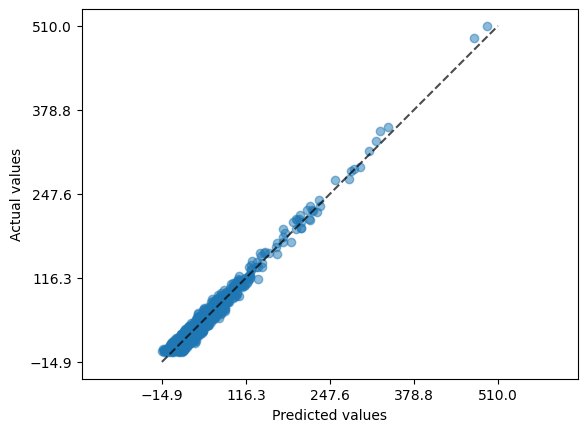

In [82]:
PredictionErrorDisplay.from_estimator(
    pipeline, X, y, kind="actual_vs_predicted", scatter_kwargs=dict(alpha=0.5)
)

In [91]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    # Remove 'alpha' from the parameter grid
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and best parameters
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the test set
y_pred = best_pipeline.predict(X_test)
test_score = mean_squared_error(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test MSE:", test_score)

Best Parameters: {}
Test MSE: 73.78939603659627
